In [331]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import pylab
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from scipy import ndimage 
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

# Import Dataset

In [332]:
df  = pd.read_csv('D:/Data Science/Coursera/Bioinformatics/Data/expression_matrix_ex1.csv')
df.head()

,pattern,1 hr,2 hr,3 hr
0,g1,10.0,8.0,10.0
1,g2,10.0,0.0,9.0
2,g3,4.0,8.5,3.0
3,g4,9.5,0.5,8.5
4,g5,4.5,8.5,2.5


In [333]:
df_new = df.set_index('pattern')
df_new = df_new.transpose()
df_new

pattern,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10
1 hr,10.0,10.0,4.0,9.5,4.5,10.5,5.0,3.7,9.7,10.2
2 hr,8.0,0.0,8.5,0.5,8.5,9.0,8.5,8.7,2.0,1.0
3 hr,10.0,9.0,3.0,8.5,2.5,12.0,11.0,2.0,9.0,9.2


Normalization

In [334]:
#for i in range(df_new.shape[1]):
    #df_new[df_new.columns.values[i]] = (df_new.iloc[:, i] - np.mean(df_new.iloc[:, i]))/np.std(df_new.iloc[:, i])
#df_new

# Hierarchical Clustering

<h3>Pearsonr Distance Matrix</h3> 

Getting Pearsonr corelation 

In [335]:
def Get_Pearsonr_Correlation(x, y):
    numer = 0
    denom_1 = 0
    denom_2 = 0
    
    for i in range(len(x)):
        
        numer = numer + (x[i] - np.mean(x))*(y[i] - np.mean(y))
        denom_1 = denom_1 + (x[i] - np.mean(x))**2
        denom_2 = denom_2 + (y[i] - np.mean(y))**2
        
    denom = np.sqrt(denom_1*denom_2)
    cor = numer/denom
    return(cor)
        

Getting distance matrix by pearsonr correlation

In [336]:
def Get_Pearsonr_Distance_Matrix(df):
    N = len(df.columns.values)
    matrix = np.zeros((N, N))
    
    for i in range(N):
        for j in range(N):
            if i != j:
                # Using library Scipy.stats.pearsonr
                #m = stats.pearsonr(df.iloc[:, i], df.iloc[:,  j])[0]
                # Using definition
                m = Get_Pearsonr_Correlation(df.iloc[:, i], df.iloc[:,  j])
                m = 1 - m
                matrix[i][j] = m
            else:
                matrix[i][j] = 0
    return(matrix)   
    

<h3> Euclidean Distance Matrix</h3>

Getting Euclidean corelation 

In [337]:
def Get_Euclidean_Distance(x, y):
    dist = 0
    for i in range(len(x)):
        dist = dist + (x[i] - y[i])**2
    dist = np.sqrt(dist)
    dist = round(dist, 1)
    return(dist)

Getting distance matrix by Euclidean correlation

In [338]:
def Get_Euclidean_Distance_Matrix(df):
    N = len(df.columns.values)
    matrix = np.zeros((N, N))
    
    for i in range(N):
        for j in range(N):
            if i != j:
                m = Get_Euclidean_Distance(df.iloc[:, i], df.iloc[:,  j])
                matrix[i][j] = m
            else:
                matrix[i][j] = 0
    return(matrix)   

In [339]:
dist_matrix = Get_Euclidean_Distance_Matrix(df_new)
dist_matrix

array([[ 0. ,  8.1,  9.2,  7.7,  9.3,  2.3,  5.1, 10.2,  6.1,  7. ],
       [ 8.1,  0. , 12. ,  0.9, 12. ,  9.5, 10.1, 12.8,  2. ,  1. ],
       [ 9.2, 12. ,  0. , 11.2,  0.7, 11.1,  8.1,  1.1, 10.5, 11.5],
       [ 7.7,  0.9, 11.2,  0. , 11.2,  9.2,  9.5, 12. ,  1.6,  1.1],
       [ 9.3, 12. ,  0.7, 11.2,  0. , 11.2,  8.5,  1. , 10.6, 11.6],
       [ 2.3,  9.5, 11.1,  9.2, 11.2,  0. ,  5.6, 12.1,  7.7,  8.5],
       [ 5.1, 10.1,  8.1,  9.5,  8.5,  5.6,  0. ,  9.1,  8.3,  9.3],
       [10.2, 12.8,  1.1, 12. ,  1. , 12.1,  9.1,  0. , 11.4, 12.4],
       [ 6.1,  2. , 10.5,  1.6, 10.6,  7.7,  8.3, 11.4,  0. ,  1.1],
       [ 7. ,  1. , 11.5,  1.1, 11.6,  8.5,  9.3, 12.4,  1.1,  0. ]])

In [340]:
dfm = pd.DataFrame(dist_matrix, columns = df_new.columns.values)
dfm['index'] = df_new.columns.values
dfm.set_index('index', inplace = True)
dfm

,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10
index,,,,,,,,,,
g1,0.0,8.1,9.2,7.7,9.3,2.3,5.1,10.2,6.1,7.0
g2,8.1,0.0,12.0,0.9,12.0,9.5,10.1,12.8,2.0,1.0
g3,9.2,12.0,0.0,11.2,0.7,11.1,8.1,1.1,10.5,11.5
g4,7.7,0.9,11.2,0.0,11.2,9.2,9.5,12.0,1.6,1.1
g5,9.3,12.0,0.7,11.2,0.0,11.2,8.5,1.0,10.6,11.6
g6,2.3,9.5,11.1,9.2,11.2,0.0,5.6,12.1,7.7,8.5
g7,5.1,10.1,8.1,9.5,8.5,5.6,0.0,9.1,8.3,9.3
g8,10.2,12.8,1.1,12.0,1.0,12.1,9.1,0.0,11.4,12.4
g9,6.1,2.0,10.5,1.6,10.6,7.7,8.3,11.4,0.0,1.1


Getting Hierarchical Clustering

In [341]:
def Get_Hierarchical_Clustering(df, dist_type):
    D = df[::]
    Clusters = D.columns.values.tolist()
    
    while len(Clusters) > 1:
        
        d = []
        pair = []
        z = []
        
        for k in (range(len(Clusters))):
            for l in (range(len(Clusters))):
                if k != l and k<l:
                    d.append(D.iloc[k, l])
                    pair.append([Clusters[k], Clusters[l]])   
                    
        index = np.argmin(d)
        
        nodes = pair[index]
        u = D[nodes[0]].tolist()
        v = D[nodes[1]].tolist()
        a = (D.columns.values == nodes[0]).tolist().index(True)
        b = (D.columns.values == nodes[1]).tolist().index(True)
        u = np.delete(u, (a, b))
        v = np.delete(v, (a, b))
        Clusters.remove(nodes[0])
        Clusters.remove(nodes[1])
        
        # With the average distance method
        if dist_type == 'average':
            for i in range(len(Clusters)):
                #new_col = np.delete(df[cl].tolist(), (a, b))
                t = len(nodes[0])*u[i] + len(nodes[1])*v[i]
                t = t/(len(nodes[0]) + len(nodes[1]))
                z.append(t)
        # With the min distance method
        elif dist_type == 'min':
            for i in range(len(u)):
                z.append(min(u[i], v[i]))
                
        D.drop(nodes, axis = 0, inplace = True)
        D.drop(nodes, axis = 1, inplace = True)
        new_node = nodes[0]+','+ nodes[1]
        D[new_node] = z
        z.append(0)
        D.loc[new_node, :] = z
        
        Clusters.append(new_node)
        print(nodes)

In [346]:
Get_Hierarchical_Clustering(dfm, 'average')

['g3', 'g5']
['g2', 'g4']
['g8', 'g3,g5']
['g10', 'g2,g4']
['g9', 'g10,g2,g4']
['g1', 'g6']
['g7', 'g1,g6']
['g9,g10,g2,g4', 'g7,g1,g6']
['g8,g3,g5', 'g9,g10,g2,g4,g7,g1,g6']


C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<h3>Using the Library of Scipy to Test and to Draw the Graph</h3>

In [442]:
def Get_Graph(df):
    Z = hierarchy.linkage(df, 'average')
    fig = pylab.figure(figsize=(15,20))
    def llf(id):
        return '[%s]' % (df.columns.values[id]) 
    
    dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'left')

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


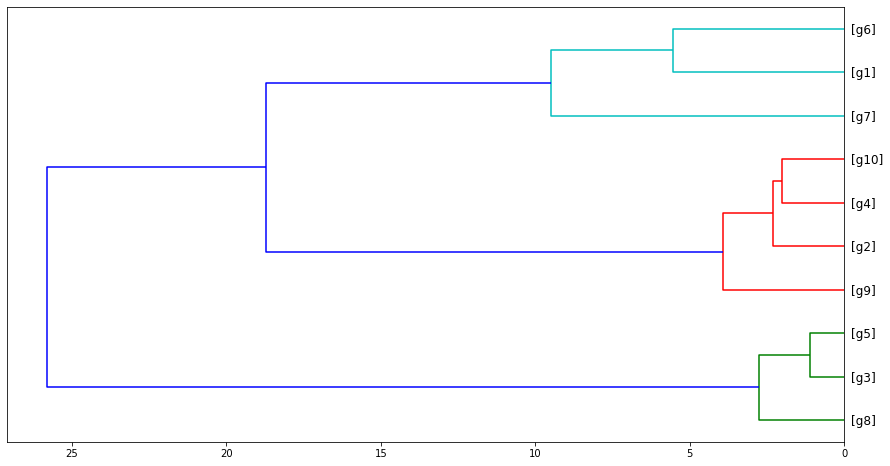

In [353]:
Get_Graph(dfm)

# Evolutionary Tree

In [354]:
df_ev_tree = pd.read_csv('D:/Data Science/Coursera/Bioinformatics/Data/mtDNA.csv')
df_ev_tree.head()

,species,mtDNA
0,W._Pygmy_(1)_{African},TTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTC...
1,W._Pygmy_(6)_{African},TTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTC...
2,Kung_(7)_{African},TTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTC...
3,Kung_(9)_{African},TTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTC...
4,Kung_(10)_{African},TTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTC...


In [384]:
def Get_Different_String(X, Y):
    count = 0
    for x, y in zip(X, Y):
        if x != y:
            count += 1
    return(count)

In [437]:
def Get_Species_Expression_Matrix(df):
    row = df.iloc[:, 1]
    l = len(row)
    mt = np.zeros((l, l))
    name = df.iloc[:, 0]
    pair_name = []
    
    for i in range(len(row)): 
        for j in range(len(row)):
            
            mt[i, j] = Get_Different_String(row[i], row[j])
                
    expression_matrix = pd.DataFrame(mt, name)
    old_col = expression_matrix.columns.values
    expression_matrix.rename(columns = dict(zip(old_col, name)), inplace = True)
        
    return(expression_matrix)
                

In [439]:
species_expression_matrix = Get_Species_Expression_Matrix(df_ev_tree)
species_expression_matrix

,W._Pygmy_(1)_{African},W._Pygmy_(6)_{African},Kung_(7)_{African},Kung_(9)_{African},Kung_(10)_{African},Kung_(13)_{African},Kung_(17)_{African},Kung_(19)_{African},Kung_(22)_{African},Asian_(23)_{Asian},...,European_(114)_{European},European_(115)_{European},European_(116)_{European},European_(117)_{European},European_(118)_{European},European_(119)_{European},European_(120)_{European},Asian_(122)_{Asian},Asian_(126)_{Asian},Asian_(128)_{Asian}
species,,,,,,,,,,,,,,,,,,,,,
W._Pygmy_(1)_{African},0.0,9.0,15.0,13.0,15.0,15.0,16.0,12.0,16.0,20.0,...,16.0,18.0,17.0,18.0,16.0,19.0,20.0,20.0,22.0,21.0
W._Pygmy_(6)_{African},9.0,0.0,15.0,15.0,15.0,17.0,20.0,14.0,18.0,18.0,...,14.0,16.0,13.0,14.0,14.0,15.0,18.0,16.0,18.0,17.0
Kung_(7)_{African},15.0,15.0,0.0,2.0,2.0,4.0,9.0,3.0,13.0,17.0,...,13.0,15.0,12.0,13.0,11.0,10.0,13.0,13.0,15.0,12.0
Kung_(9)_{African},13.0,15.0,2.0,0.0,4.0,6.0,11.0,5.0,11.0,17.0,...,13.0,15.0,12.0,13.0,11.0,10.0,13.0,13.0,15.0,12.0
Kung_(10)_{African},15.0,15.0,2.0,4.0,0.0,2.0,9.0,3.0,13.0,17.0,...,13.0,15.0,12.0,13.0,11.0,10.0,13.0,13.0,15.0,12.0
Kung_(13)_{African},15.0,17.0,4.0,6.0,2.0,0.0,9.0,3.0,11.0,17.0,...,13.0,17.0,14.0,15.0,13.0,12.0,13.0,15.0,17.0,14.0
Kung_(17)_{African},16.0,20.0,9.0,11.0,9.0,9.0,0.0,6.0,16.0,20.0,...,14.0,16.0,15.0,16.0,14.0,15.0,16.0,15.0,18.0,15.0
Kung_(19)_{African},12.0,14.0,3.0,5.0,3.0,3.0,6.0,0.0,10.0,14.0,...,10.0,14.0,11.0,12.0,10.0,11.0,12.0,12.0,14.0,11.0
Kung_(22)_{African},16.0,18.0,13.0,11.0,13.0,11.0,16.0,10.0,0.0,18.0,...,16.0,20.0,17.0,18.0,16.0,17.0,18.0,18.0,19.0,17.0


In [440]:
Get_Hierarchical_Clustering(species_expression_matrix, 'average')

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['Asian_(28)_{Asian}', 'Yoruban_(29)_{African}']
['W._Pygmy_(37)_{African}', 'W._Pygmy_(40)_{African}']
['European_(114)_{European}', 'European_(116)_{European}']
['W._Pygmy_(38)_{African}', 'W._Pygmy_(37)_{African},W._Pygmy_(40)_{African}']
['European_(117)_{European}', 'European_(114)_{European},European_(116)_{European}']
['European_(118)_{European}', 'European_(117)_{European},European_(114)_{European},European_(116)_{European}']
['Kung_(7)_{African}', 'Kung_(9)_{African}']
['Kung_(10)_{African}', 'Kung_(13)_{African}']
['E._Pygmy_(69)_{African}', 'E._Pygmy_(73)_{African}']
['Yoruban_(26)_{African}', 'Asian_(28)_{Asian},Yoruban_(29)_{African}']
['Kung_(19)_{African}', 'Kung_(10)_{African},Kung_(13)_{African}']
['W._Pygmy_(46)_{African}', 'W._Pygmy_(48)_{African}']
['E._Pygmy_(70)_{African}', 'E._Pygmy_(69)_{African},E._Pygmy_(73)_{African}']
['European_(89)_{European}', 'Asian_(90)_{Asian}']
['European_(94)_{European}', 'Asian_(95)_{Asian}']
['European_(119)_{European}', 'European_

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


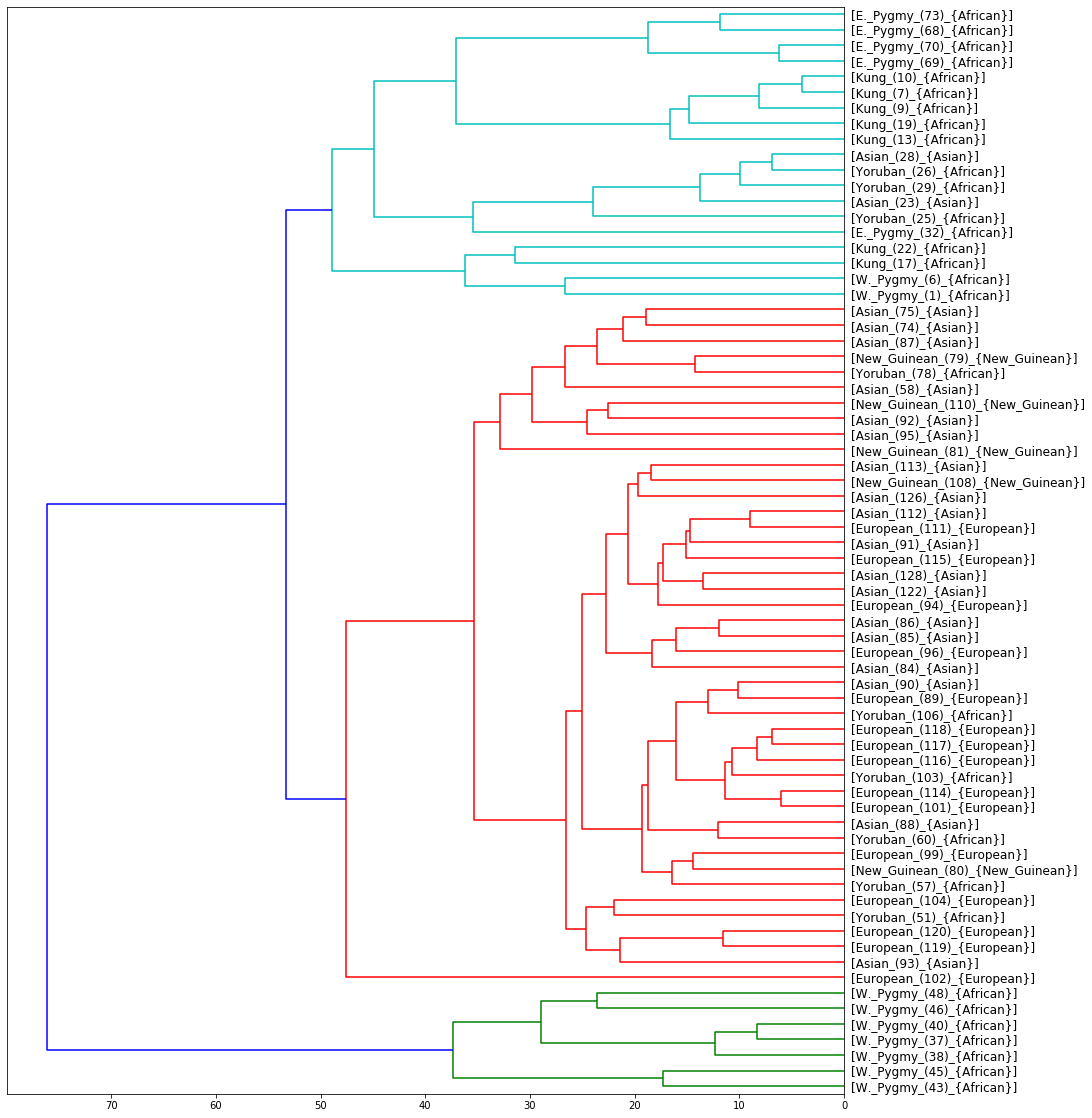

In [443]:
Get_Graph(species_expression_matrix)